# GPU Acceleration

If you have an NVIDIA GPU, you can accelerate large and challenging optimization problems with the GPU. For this, install the RydOpt software with GPU support via `pip install rydopt[cuda12]` and set the JAX_PLATFORMS environment variable as follows:

In [1]:
# %pip install -q --progress-bar off rydopt[cuda12] # Uncomment for installation on Colab

import os

os.environ["JAX_PLATFORMS"] = "cuda,cpu"

Optionally, if you do not need double precision, you can set JAX_ENABLE_X64 to false for further accelerating the optimization. 

In [2]:
os.environ["JAX_ENABLE_X64"] = "false"

Afterwards, you can write your code as usual. To profit from the GPU acceleration, the optimization problem should be challenging enough. Thus, as an example problem, we search for a time-optimal pulse realizing a CCCZ gate.


Started optimization using 1 process



proc00:   0%|                                                                           | 0/1000 [00:00<?, ?it…


=== Optimization finished using multi-start Adam ===

Duration: 235.229 seconds
Gates with infidelity below tol=1.0e-05: 50

Slowest gate:
> infidelity <= tol
> parameters = (17.043794631958008, [-0.84649849  0.34067026 -0.5356636  -1.75986195 -0.26940626  1.22787535
  0.50804079  1.79584825  1.77759826], [], [])
> duration = 17.043794631958008

Fastest gate:
> infidelity <= tol
> parameters = (12.383313179016113, [ 1.31666899 -1.32707393 -1.73134279  1.0573504  -1.35030437  1.66573513
 -1.01142657  0.52365202  1.40412855], [], [])
> duration = 12.383313179016113
> one-sided bootstrap error on duration: 0.1


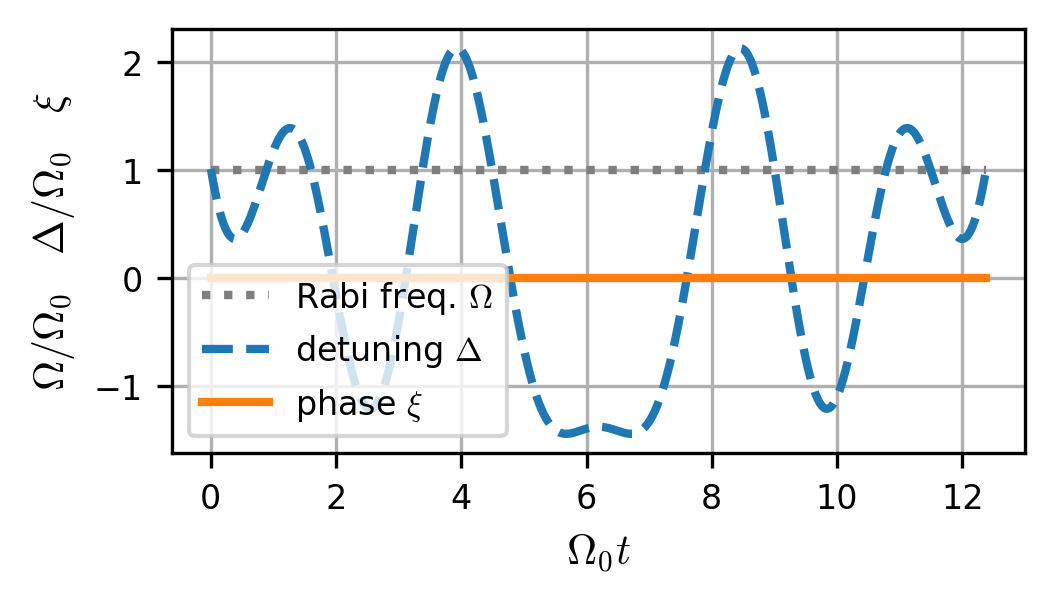

In [3]:
import rydopt as ro
import numpy as np

# Want a CCCZ gate on two atoms in the perfect blockade regime; no Rydberg state decay
gate = ro.gates.FourQubitGatePyramidal(
    phi=None,
    theta=np.pi,
    theta_prime=np.pi,
    lamb=np.pi,
    lamb_prime=np.pi,
    kappa=np.pi,
    Vnn=float("inf"),
    Vnnn=float("inf"),
    decay=0.0,
)

# Pulse ansatz: constant detuning, sweep of the laser phase according to sin_crab ansatz
pulse_ansatz = ro.pulses.PulseAnsatz(detuning_ansatz=ro.pulses.const_cos_crab)

# Initial pulse parameter guess:
# duration, detuning parameters, phase parameters, Rabi parameters
min_initial_params = (
    11.0,
    [-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0],
    [],
    [],
)
max_initial_params = (
    13.0,
    [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0],
    [],
    [],
)

# Optimize the pulse parameters
opt_result = ro.optimization.multi_start_optimize(
    gate,
    pulse_ansatz,
    min_initial_params,
    max_initial_params,
    num_steps=1000,
    tol=1e-5,
    num_initializations=10000,
    min_converged_initializations=50,
)
optimized_params = opt_result.params

# Plot the pulse
ro.characterization.plot_pulse(pulse_ansatz, optimized_params)